# Import bibliotek

In [111]:
import pandas as pd
from sklearn.cluster import KMeans

In [112]:
data_rfm = pd.read_parquet('df.parquet')
data_norm = data_rfm[["log_R", "log_F", "log_M"]]

# Dobór parametrów
Aby dobrać parametry trzeba użyć elbow method.

In [113]:
'''
import seaborn as sns
import matplotlib.pyplot as plt

sse = {}
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=1)
    kmeans.fit(data_norm)
    sse[k] = kmeans.inertia_

plt.title('Metoda punktu łokciowego')
plt.xlabel('Liczba klastrów')
plt.ylabel('Suma kwadratów odległości')
plt.axvline(c='r', linestyle='--', x=2)
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()
'''

"\nimport seaborn as sns\nimport matplotlib.pyplot as plt\n\nsse = {}\nfor k in range(1, 11):\n    kmeans = KMeans(n_clusters=k, random_state=1)\n    kmeans.fit(data_norm)\n    sse[k] = kmeans.inertia_\n\nplt.title('Metoda punktu łokciowego')\nplt.xlabel('Liczba klastrów')\nplt.ylabel('Suma kwadratów odległości')\nplt.axvline(c='r', linestyle='--', x=2)\nsns.pointplot(x=list(sse.keys()), y=list(sse.values()))\nplt.show()\n"

Wybieramy 3

# Algorytm

In [114]:
from sklearn.cluster import KMeans

n_clusters = 3
model = KMeans(n_clusters = n_clusters)
model.fit(data_norm)
clusters = model.predict(data_norm)

In [115]:
data_rfm["Cluster"] = clusters
print(data_rfm['Cluster'].dtype)
data_rfm['Cluster'] = data_rfm['Cluster'].apply(str)
print(data_rfm['Cluster'].dtype)

int32
object


# Analiza wyników

### Wykresy

In [116]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

sns.set_style("whitegrid")
data_rfm['Cluster'] = data_rfm['Cluster'].apply(str)


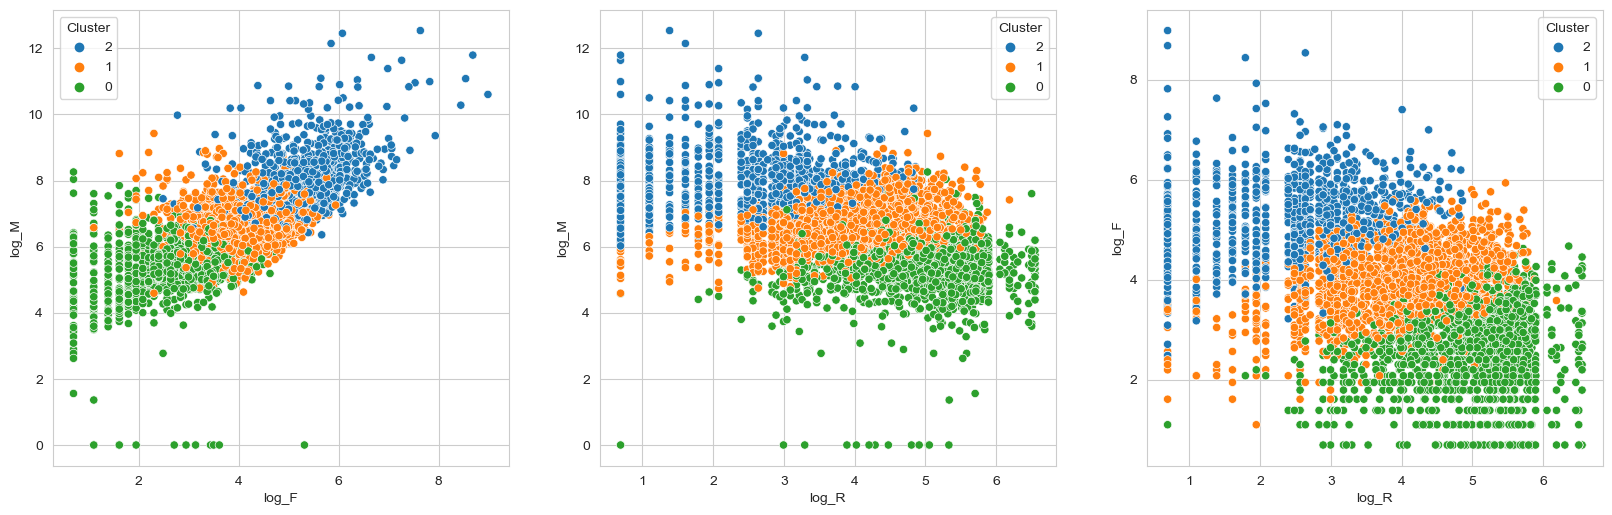

In [117]:
    f, axes = plt.subplots(1, 3, subplot_kw=dict(box_aspect=1), figsize=(20, 20))
    sns.scatterplot(data=data_rfm, x='log_F', y='log_M', hue='Cluster', ax=axes[0])
    sns.scatterplot(data=data_rfm, x='log_R', y='log_M', hue='Cluster', ax=axes[1])
    sns.scatterplot(data=data_rfm, x='log_R', y='log_F', hue='Cluster', ax=axes[2])
    plt.show()

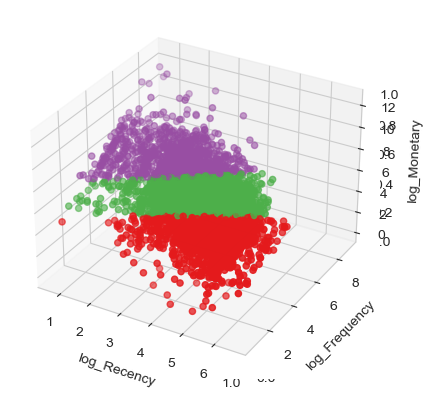

In [118]:
fig = plt.figure()
ax = plt.axes(projection='3d')
cmap = ListedColormap(sns.color_palette("Set1", 256).as_hex())
sns_plot = plt.axes (projection='3d')
sns_plot.scatter3D(data_rfm['log_R'], data_rfm['log_F'], data_rfm['log_M'],
                       c=data_rfm['Cluster'].apply(int), cmap=cmap)
sns_plot.set_xlabel ('log_Recency')
sns_plot.set_ylabel ('log_Frequency')
sns_plot.set_zlabel ('log_Monetary')
plt.show ()

### Analiza biznesowa

In [119]:
df_table = data_rfm.groupby('Cluster').agg({'Cluster': 'count','R_score': 'mean', 'F_score': 'mean', 'M_score':'mean', 'RFM_Score':'mean'})

df_result = data_rfm.groupby('Cluster').agg({'Cluster': 'count','R_score': 'mean', 'F_score': 'mean', 'M_score':'mean', 'RFM_Score':'mean'}).round(2)

df_result = df_result.rename_axis('Klaster').rename(columns={
    'Cluster': 'Liczba klientów',
    'R_score': 'Wartość R',
    'F_score': 'Wartość F',
    'M_score': 'Wartość M',
    'RFM_Score': 'Wartość RFM'
})

df_result

,Liczba klientów,Wartość R,Wartość F,Wartość M,Wartość RFM
Klaster,,,,,
0,1528,0.63,0.42,0.44,1.49
1,1796,1.65,1.73,1.71,5.10
2,1005,2.63,2.76,2.79,8.19


### Analiza klastrów

In [120]:
from sklearn.metrics import silhouette_score,calinski_harabasz_score, davies_bouldin_score
from validclust import dunn
from scipy.spatial.distance import cdist
from sklearn.metrics import pairwise_distances

print(f'Wskaznik sylwetki: {silhouette_score(data_norm, data_rfm["Cluster"]).round(2)}')
print(f'Indeks CH: {calinski_harabasz_score(data_norm, data_rfm["Cluster"]).round(2)}')
print(f'Indeks DB: {davies_bouldin_score(data_norm, data_rfm["Cluster"]).round(2)}')
print(f'Indeks Dunn: {dunn(pairwise_distances(data_norm, metric="cityblock"), data_rfm["Cluster"]).round(5)}')

Wskaznik sylwetki: 0.3
Indeks CH: 3027.85
Indeks DB: 1.13
Indeks Dunn: 0.00321


In [121]:
def assign_label_Recency(value):
    print(value)
    if 0 < value <= 1:
        return 'Utracony'
    elif 1 < value <= 2:
        return 'Odchodzący'
    elif 2 < value <= 3:
        return 'Aktywny'


def assign_label_Frequency_or_Monetary(value):
    if 0 < value <= 1:
        return 'Niska'
    elif 1 < value <= 2:
        return 'Średnia'
    elif 2 < value <= 3:
        return 'Wysoka'

def assign_label_Frequency_and_Monetary(value):
    if 0 < value <= 1:
        return 'Niska'
    elif 1 < value <= 2:
        return 'Średnia'
    elif 2 < value <= 3:
        return 'Wysoka'

df = df_table.copy()

df['Aktywność klienta'] = df['R_score'].apply(assign_label_Recency)
df['Częstotliwość zakupów'] = df['F_score'].apply(assign_label_Frequency_and_Monetary)
df['Wartość monetarna'] = df['M_score'].apply(assign_label_Frequency_and_Monetary)
df['Kategoria klientów R, F i M'] = df.apply(lambda row: f"{row['Aktywność klienta']}, {row['Częstotliwość zakupów']} częstotliwość, {row['Wartość monetarna']} wartość monetarna", axis=1)
# Definiowanie funkcji przypisującej etykiety na podstawie wartości z kolumny 2 i Avg_FM
def assign_label_R_vs_FM(row):
    print(row)
    r_value = row['R_score']
    fm_value = (row['F_score'] + row['M_score']) / 2

    if 2 < r_value <= 3:
        if 2 < fm_value <= 3:
            fm_label = 'Czempioni'
        elif 1 < fm_value <= 2:
            fm_label = 'Obiecujący'
        elif 0 < fm_value <= 1:
            fm_label = 'Nowi klienci'

    elif 1 < r_value <= 2:
        if 2 < fm_value <= 3:
            fm_label = 'Lojalni klienci'
        elif 1 < fm_value <= 2:
            fm_label = 'Wymagają uwagi'
        elif 0 < fm_value <= 1:
            fm_label = 'Powinno się skontaktować'

    elif 0 < r_value <= 1:
        if 2 < fm_value <= 3:
            fm_label = 'Nie powinno się stracić'
        elif 1 < fm_value <= 2:
            fm_label = 'Odchodzący'
        elif 0 < fm_value <= 1:
            fm_label = 'Utraceni'

    return fm_label

df['Kategoria klientów R vs FM'] = df.apply(lambda row : assign_label_R_vs_FM(row), axis=1)

df = df.drop(columns=['RFM_Score', 'R_score', 'F_score', 'M_score'])
print(df)

0.6341623036649214
1.650890868596882
2.6338308457711443
Cluster                                                                     1528
R_score                                                                 0.634162
F_score                                                                  0.41623
M_score                                                                 0.439791
RFM_Score                                                               1.490183
Aktywność klienta                                                       Utracony
Częstotliwość zakupów                                                      Niska
Wartość monetarna                                                          Niska
Kategoria klientów R, F i M    Utracony, Niska częstotliwość, Niska wartość m...
Name: 0, dtype: object
Cluster                                                                     1796
R_score                                                                 1.650891
F_score                       

### Analiza algorytmu

In [122]:
with open("csv_table2.tex", 'w') as f:
    f.write(df.to_latex(index=True))

C:\Users\marce\AppData\Local\Temp\ipykernel_11564\2607139792.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  f.write(df.to_latex(index=True))


In [123]:
import timeit

n = 10
stmt = '''
model = KMeans(n_clusters = n_clusters)
model.fit(data_norm)
clusters = model.predict(data_norm)
'''
result = timeit.timeit(stmt=stmt, globals=globals(), number=n)

print(f"Średni czas wykonania wynosi  {round(result / n, 3)} sekund")

Średni czas wykonania wynosi  0.056 sekund


In [124]:
def assign_label_Recency(value):
    print(value)
    if 0 < value <= 1:
        return 'Utracony'
    elif 1 < value <= 2:
        return 'Odchodzący'
    elif 2 < value <= 3:
        return 'Aktywny'


def assign_label_Frequency_or_Monetary(value):
    if 0 < value <= 1:
        return 'Niska'
    elif 1 < value <= 2:
        return 'Średnia'
    elif 2 < value <= 3:
        return 'Wysoka'

df = df_table.copy()

df['Aktywność klienta'] = df['R_score'].apply(assign_label_Recency)
df['Częstotliwość zakupów'] = df['F_score'].apply(assign_label_Frequency_or_Monetary)
df['Wartość monetarna'] = df['M_score'].apply(assign_label_Frequency_or_Monetary)
df['Kategoria klientów R, F i M'] = df.apply(lambda row: f"{row['Aktywność klienta']}, {row['Częstotliwość zakupów']} częstotliwość, {row['Wartość monetarna']} wartość monetarna", axis=1)



def assign_label_R_vs_FM(row):
    print(row)
    r_value = row['R_score']
    fm_value = (row['F_score'] + row['M_score']) / 2

    if 2 < r_value <= 3:
        if 2 < fm_value <= 3:
            fm_label = 'Czempioni'
        elif 1 < fm_value <= 2:
            fm_label = 'Obiecujący'
        elif 0 < fm_value <= 1:
            fm_label = 'Nowi klienci'

    elif 1 < r_value <= 2:
        if 2 < fm_value <= 3:
            fm_label = 'Lojalni klienci'
        elif 1 < fm_value <= 2:
            fm_label = 'Wymagają uwagi'
        elif 0 < fm_value <= 1:
            fm_label = 'Powinno się skontaktować'

    elif 0 < r_value <= 1:
        if 2 < fm_value <= 3:
            fm_label = 'Nie powinno się stracić'
        elif 1 < fm_value <= 2:
            fm_label = 'Odchodzący'
        elif 0 < fm_value <= 1:
            fm_label = 'Utraceni'

    return fm_label

df['Kategoria klientów R vs FM'] = df.apply(lambda row : assign_label_R_vs_FM(row), axis=1)


0.6341623036649214
1.650890868596882
2.6338308457711443
Cluster                                                                     1528
R_score                                                                 0.634162
F_score                                                                  0.41623
M_score                                                                 0.439791
RFM_Score                                                               1.490183
Aktywność klienta                                                       Utracony
Częstotliwość zakupów                                                      Niska
Wartość monetarna                                                          Niska
Kategoria klientów R, F i M    Utracony, Niska częstotliwość, Niska wartość m...
Name: 0, dtype: object
Cluster                                                                     1796
R_score                                                                 1.650891
F_score                       